<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>04 - Main Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook a *Main Model* is proposed for the *Identifying the Human Values behind Arguments* task and evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download of the Dataset

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_train_df.columns.to_list()

In [5]:
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
    split_dataframes(arguments_train_df, labels_train_df, seed=SEED)

# Model and Tokenizer Definition

In [6]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'bert-base-uncased'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, problem_type='multi_label_classification')

# Add the tokens encoding the stance to the tokenizer.
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

# Build a dictionary to encde the stance.
stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [8]:
from src.models.transformer_model  import get_transformer_model

model = get_transformer_model(MODEL_NAME, num_labels=len(TARGETS),
                              tokenizer=tokenizer, device=DEVICE)

In [9]:
print('Model structure:')
print(model)

Model structure:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## Training

### Create Dataloaders

In [10]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_TRAIN = 16
BATCH_SIZE_EVAL = 16

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                             stance_encoder, batch_size=BATCH_SIZE_TRAIN,
                             shuffle=True, use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                             stance_encoder, batch_size=BATCH_SIZE_EVAL,
                             shuffle=False, use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                             stance_encoder, batch_size=BATCH_SIZE_EVAL,
                             shuffle=False, use_augmentation=False)

### Training parameters

In [11]:
import os
from torch.optim import Adam
from src.training.training_utils import Checkpoint, EarlyStopping, FocalLoss

# Set the number of epochs.
EPOCHS = 15
# Set the learning rates for the Bert model and the Classification head.
LEARNING_RATE_BERT = 2e-05
LEARNING_RATE_CLASSIFIER = 1e-03
# Set how many training steps to use for validation.
STEPS_VALIDATE = 200

# Set the loss function.
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df))
train_labels_frequencies = train_labels_frequencies.to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Set the optimizer.
optimizer = Adam(params=[
    { 'params': model.bert.parameters(), 'lr': LEARNING_RATE_BERT },
    { 'params': model.dropout.parameters(), 'lr': LEARNING_RATE_CLASSIFIER },
    { 'params': model.classifier.parameters(), 'lr': LEARNING_RATE_CLASSIFIER }
    ])

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models', 'main_model.pth'))
early_stopping = EarlyStopping()

### Training

In [12]:
from src.training.training import train

# Train the model.
train_loss_history, val_loss_history, val_f1_macro_history = train(
    train_loader, val_loader, model, optimizer, loss_function, DEVICE,
    epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
    early_stopping=early_stopping, reload_best_weights=True,
    use_threshold_selection=True)

epoch: 1/15, 199/270, 46s 230ms/step, loss: 0.0604                
validate: 5s, validation loss: 0.0538, validation f1 macro: 43.9 %                
epoch: 1/15, 270/270, 65s 242ms/step, loss: 0.0592                
---------------------------------------------------------------
epoch: 1/15, 65s, loss: 0.0592, val loss:, 0.0521, val f1 macro: 46 %
epoch: 2/15, 199/270, 43s 217ms/step, loss: 0.0521                
validate: 5s, validation loss: 0.0498, validation f1 macro: 49.6 %                
epoch: 2/15, 270/270, 63s 235ms/step, loss: 0.0519                
---------------------------------------------------------------
epoch: 2/15, 63s, loss: 0.0519, val loss:, 0.0489, val f1 macro: 51.2 %
epoch: 3/15, 199/270, 44s 219ms/step, loss: 0.0489                
validate: 5s, validation loss: 0.0494, validation f1 macro: 50.6 %                
epoch: 3/15, 270/270, 64s 237ms/step, loss: 0.0487                
---------------------------------------------------------------
epoch: 3/15, 64

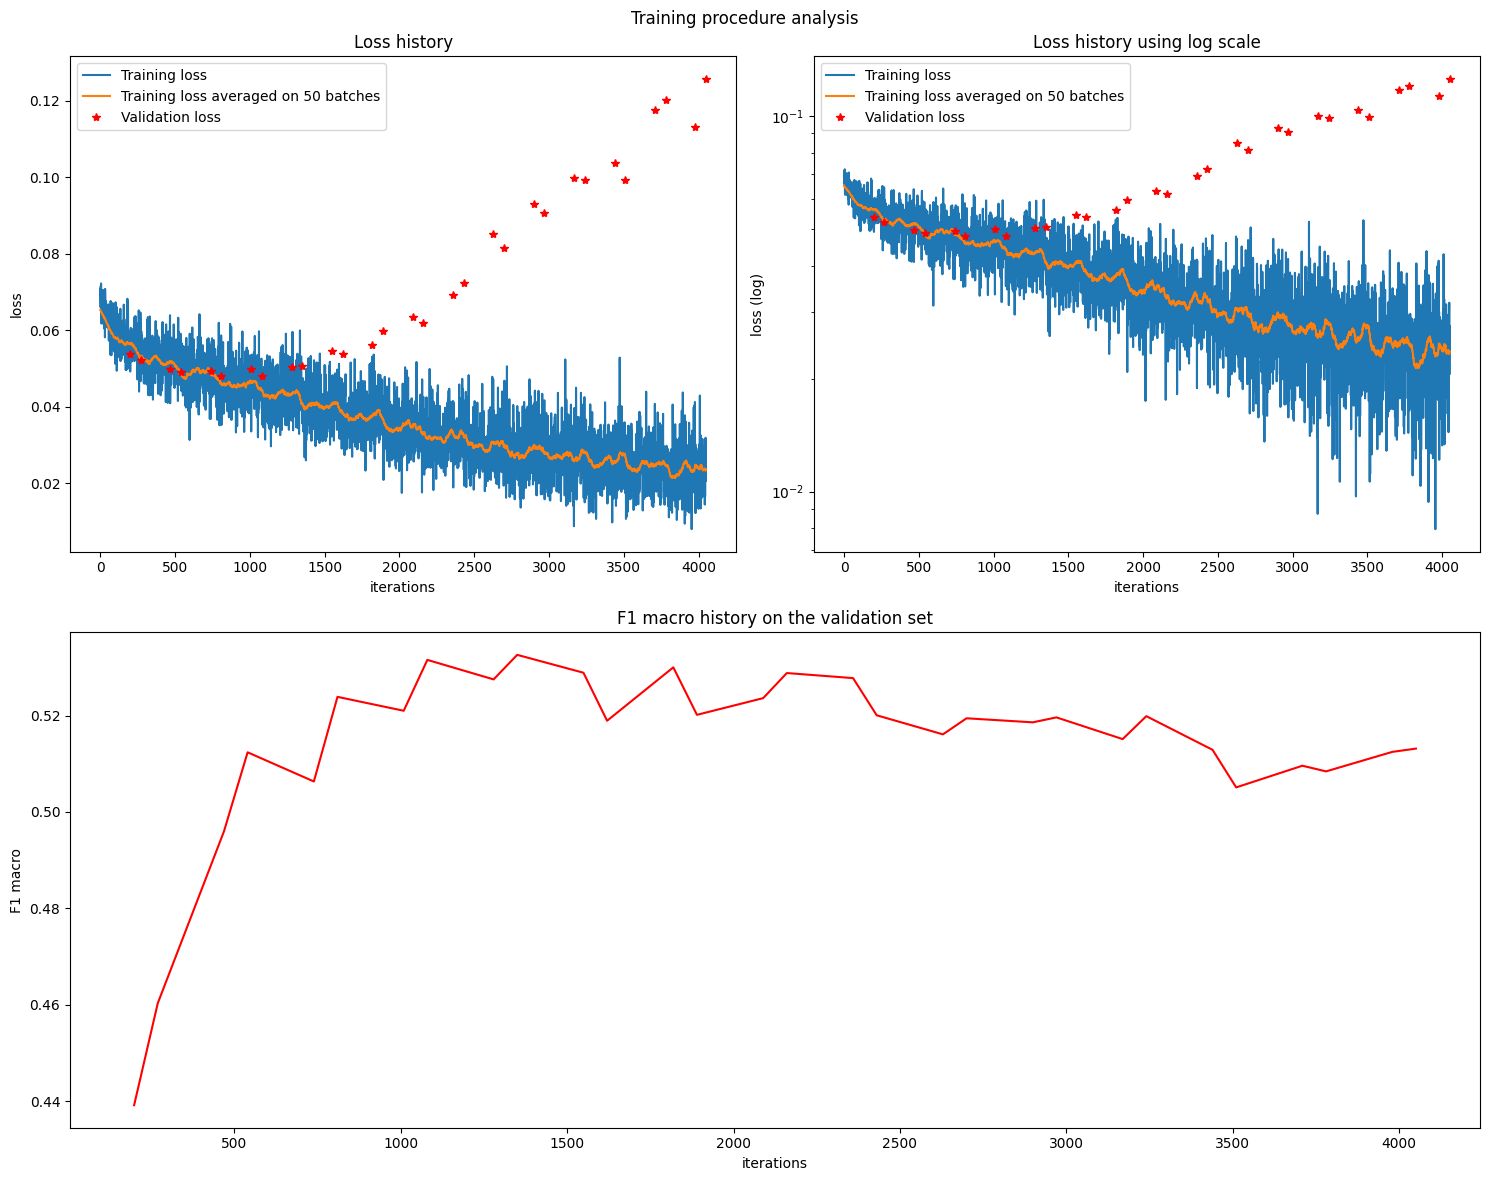

In [13]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

In [14]:
'''import torch

checkpoint = torch.load('models/main_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']'''

"import torch\n\ncheckpoint = torch.load('models/main_model.pth')\n\n# Get loss history and validation loss history\nmodel.load_state_dict(checkpoint['model_state_dict'])\ntrain_loss_history = checkpoint['train_loss_history']\nval_loss_history = checkpoint['val_loss_history']\nval_f1_macro_history = checkpoint['val_f1_macro_history']"

# Model Evaluation

## Threshold selection

Macro-averaged One-vs-Rest ROC AUC score:
0.81


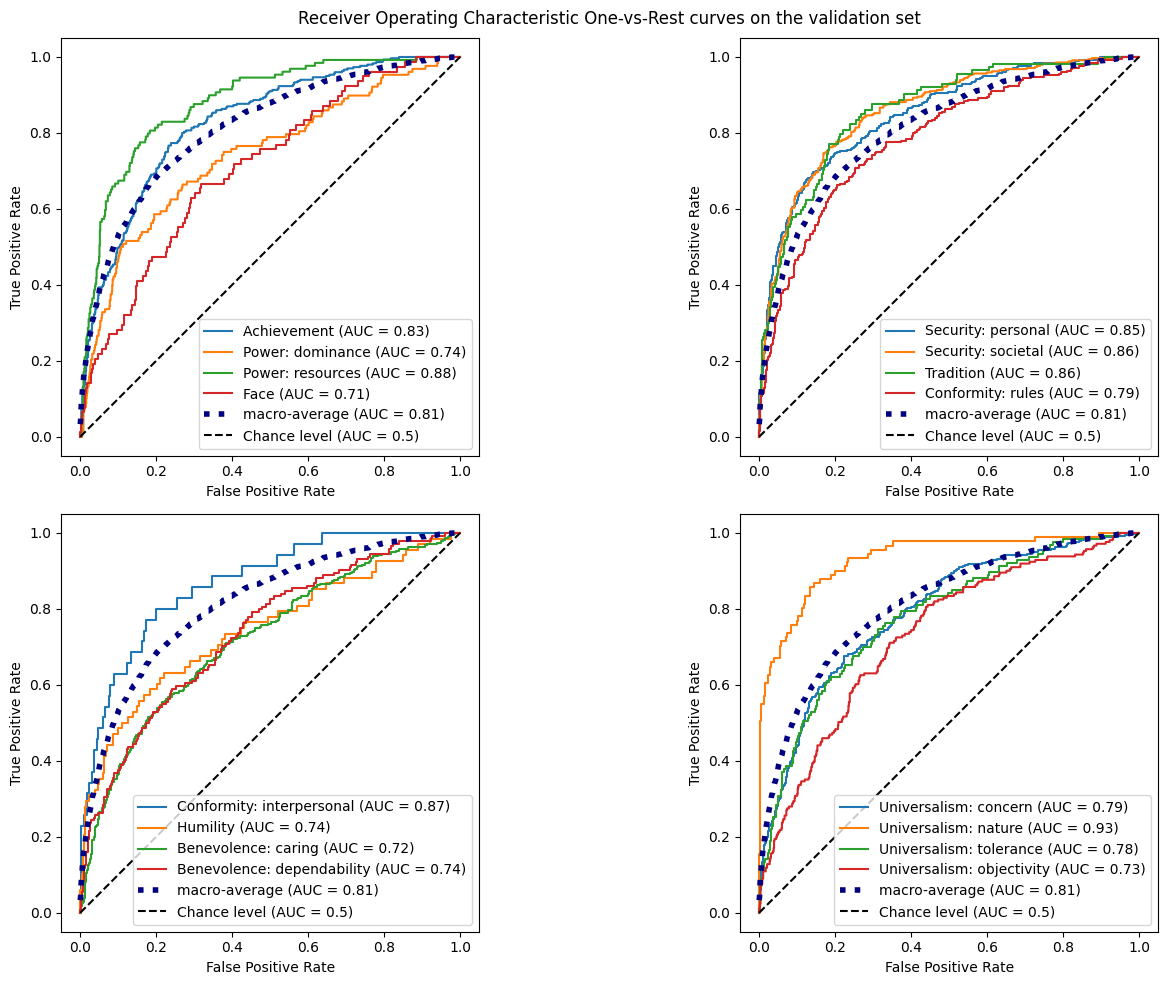

In [16]:
from src.evaluation.evaluation import get_dataset_prediction_scores
from src.evaluation.evaluation_analysis import plot_roc_curves

y_scores, y_true = get_dataset_prediction_scores(model, val_loader, DEVICE)
plot_roc_curves(y_true, y_scores, TARGETS, 'validation')

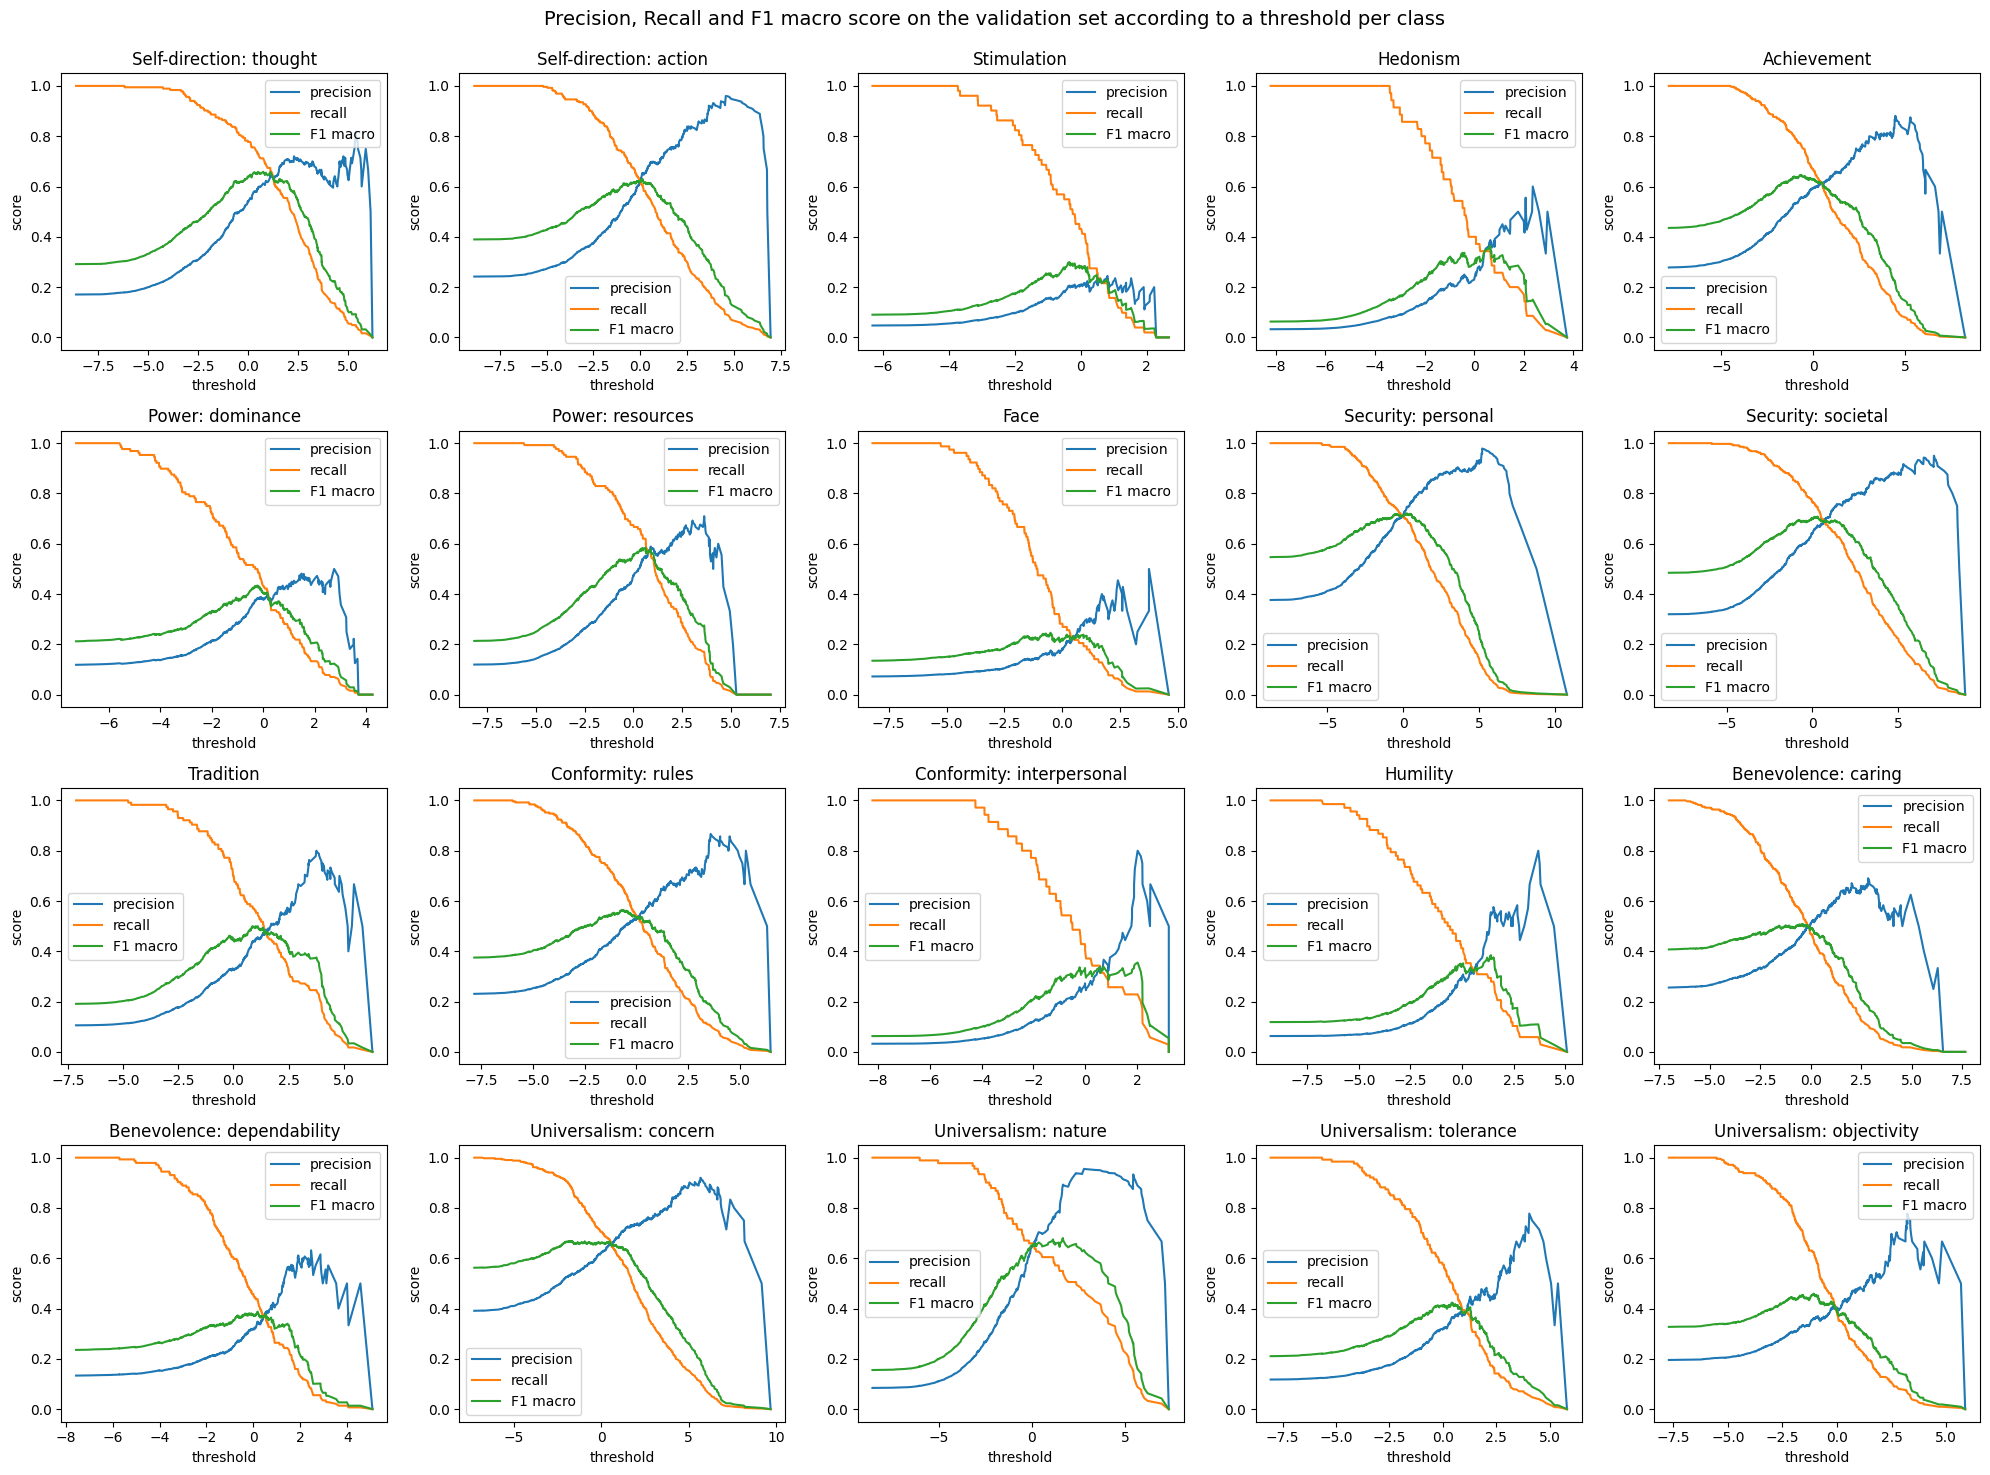

In [17]:
from src.evaluation.evaluation_analysis import (
    plot_precision_recall_f1_macro_curves)

plot_precision_recall_f1_macro_curves(y_true, y_scores, TARGETS, 'validation')

In [18]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'main_model_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: 0.7435
"Self-direction: action" best threshold: 0.1133
"Stimulation" best threshold: -0.3445
"Hedonism" best threshold: 0.6549
"Achievement" best threshold: -0.6506
"Power: dominance" best threshold: -0.2241
"Power: resources" best threshold: 0.6253
"Face" best threshold: -0.4958
"Security: personal" best threshold: 0.2353
"Security: societal" best threshold: 0.2942
"Tradition" best threshold: 0.8610
"Conformity: rules" best threshold: -0.7375
"Conformity: interpersonal" best threshold: 2.0238
"Humility" best threshold: 1.3961
"Benevolence: caring" best threshold: -0.4309
"Benevolence: dependability" best threshold: 0.1806
"Universalism: concern" best threshold: -1.6769
"Universalism: nature" best threshold: 1.6653
"Universalism: tolerance" best threshold: 0.4260
"Universalism: objectivity" best threshold: -1.0702


## Evaluation on the Validation set

In [19]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:', 
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.485


In [20]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE,
                                         thresholds_per_target)

# Compute Validation F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with threshold',
      f'selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.513


In [21]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.62      0.71      0.66       184
    Self-direction: action       0.65      0.61      0.63       261
               Stimulation       0.21      0.55      0.30        51
                  Hedonism       0.40      0.34      0.37        35
               Achievement       0.56      0.77      0.65       300
          Power: dominance       0.39      0.50      0.44       128
          Power: resources       0.56      0.62      0.59       129
                      Face       0.18      0.41      0.25        78
        Security: personal       0.75      0.70      0.72       406
        Security: societal       0.67      0.75      0.71       345
                 Tradition       0.44      0.58      0.50       114
         Conformity: rules       0.49      0.66      0.56       249
 Conformity: interpersonal       0.89      0.23      0.36        35
 

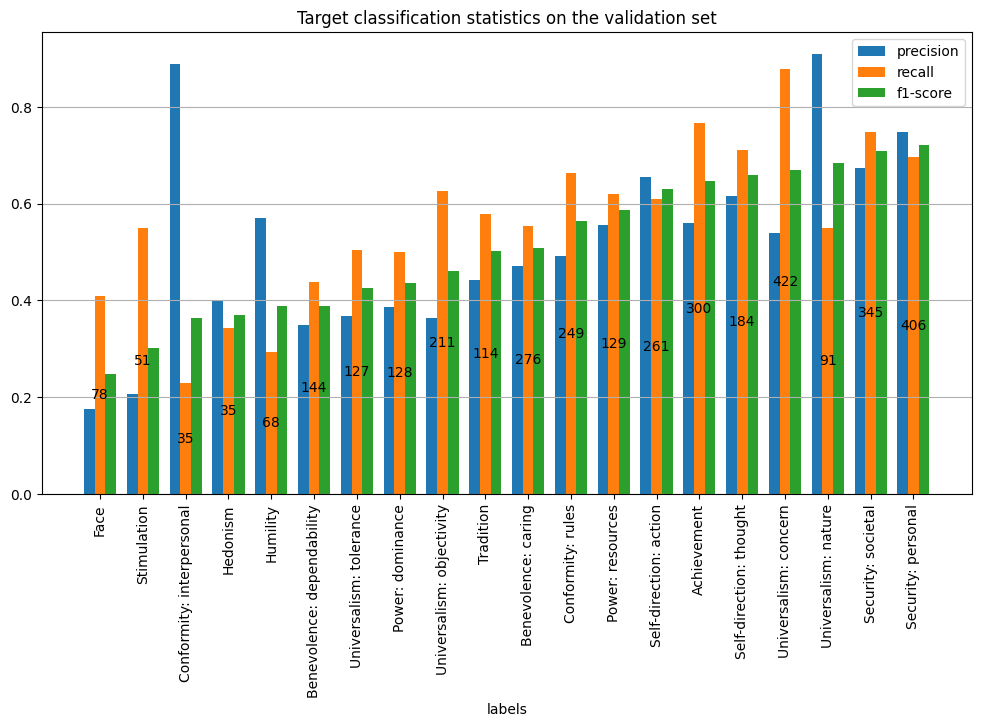

In [22]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')

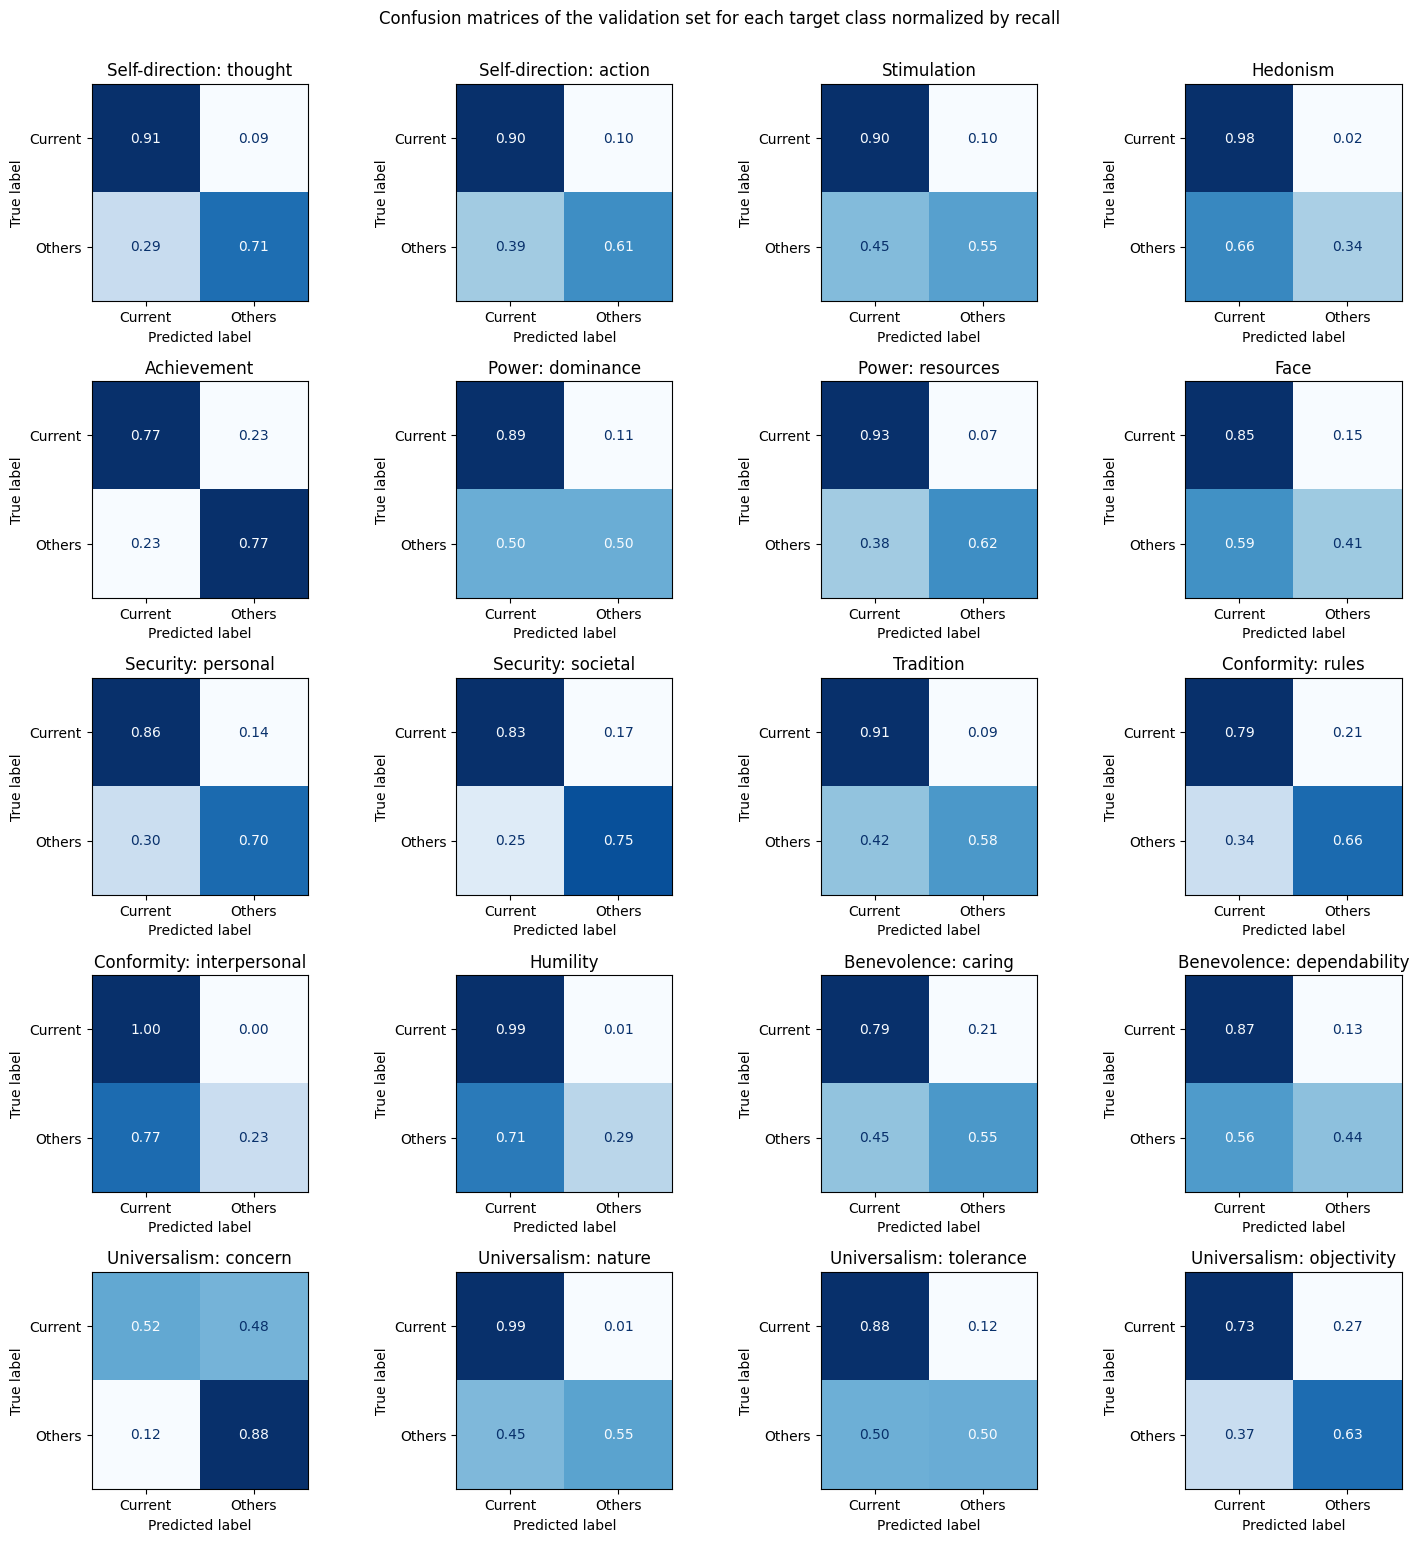

In [23]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation',
                        normalize_by='recall')

## Evaluation on the Test set

In [24]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.438


In [25]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                         thresholds_per_target)

# Compute Test F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with threshold selection:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.417


In [26]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.43      0.51      0.47       251
    Self-direction: action       0.49      0.51      0.50       496
               Stimulation       0.22      0.33      0.26       138
                  Hedonism       0.41      0.23      0.30       103
               Achievement       0.57      0.73      0.64       575
          Power: dominance       0.23      0.28      0.25       164
          Power: resources       0.44      0.55      0.49       132
                      Face       0.21      0.38      0.27       130
        Security: personal       0.74      0.71      0.72       759
        Security: societal       0.56      0.68      0.62       488
                 Tradition       0.36      0.47      0.40       172
         Conformity: rules       0.47      0.62      0.54       455
 Conformity: interpersonal       0.50      0.05      0.09        60
       

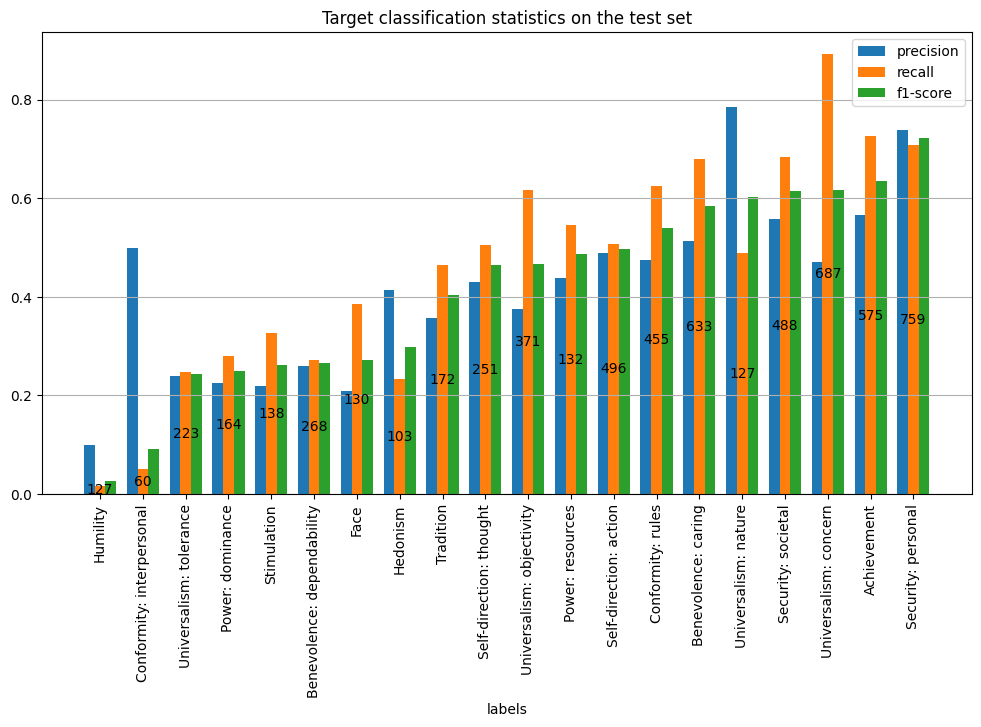

In [27]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')

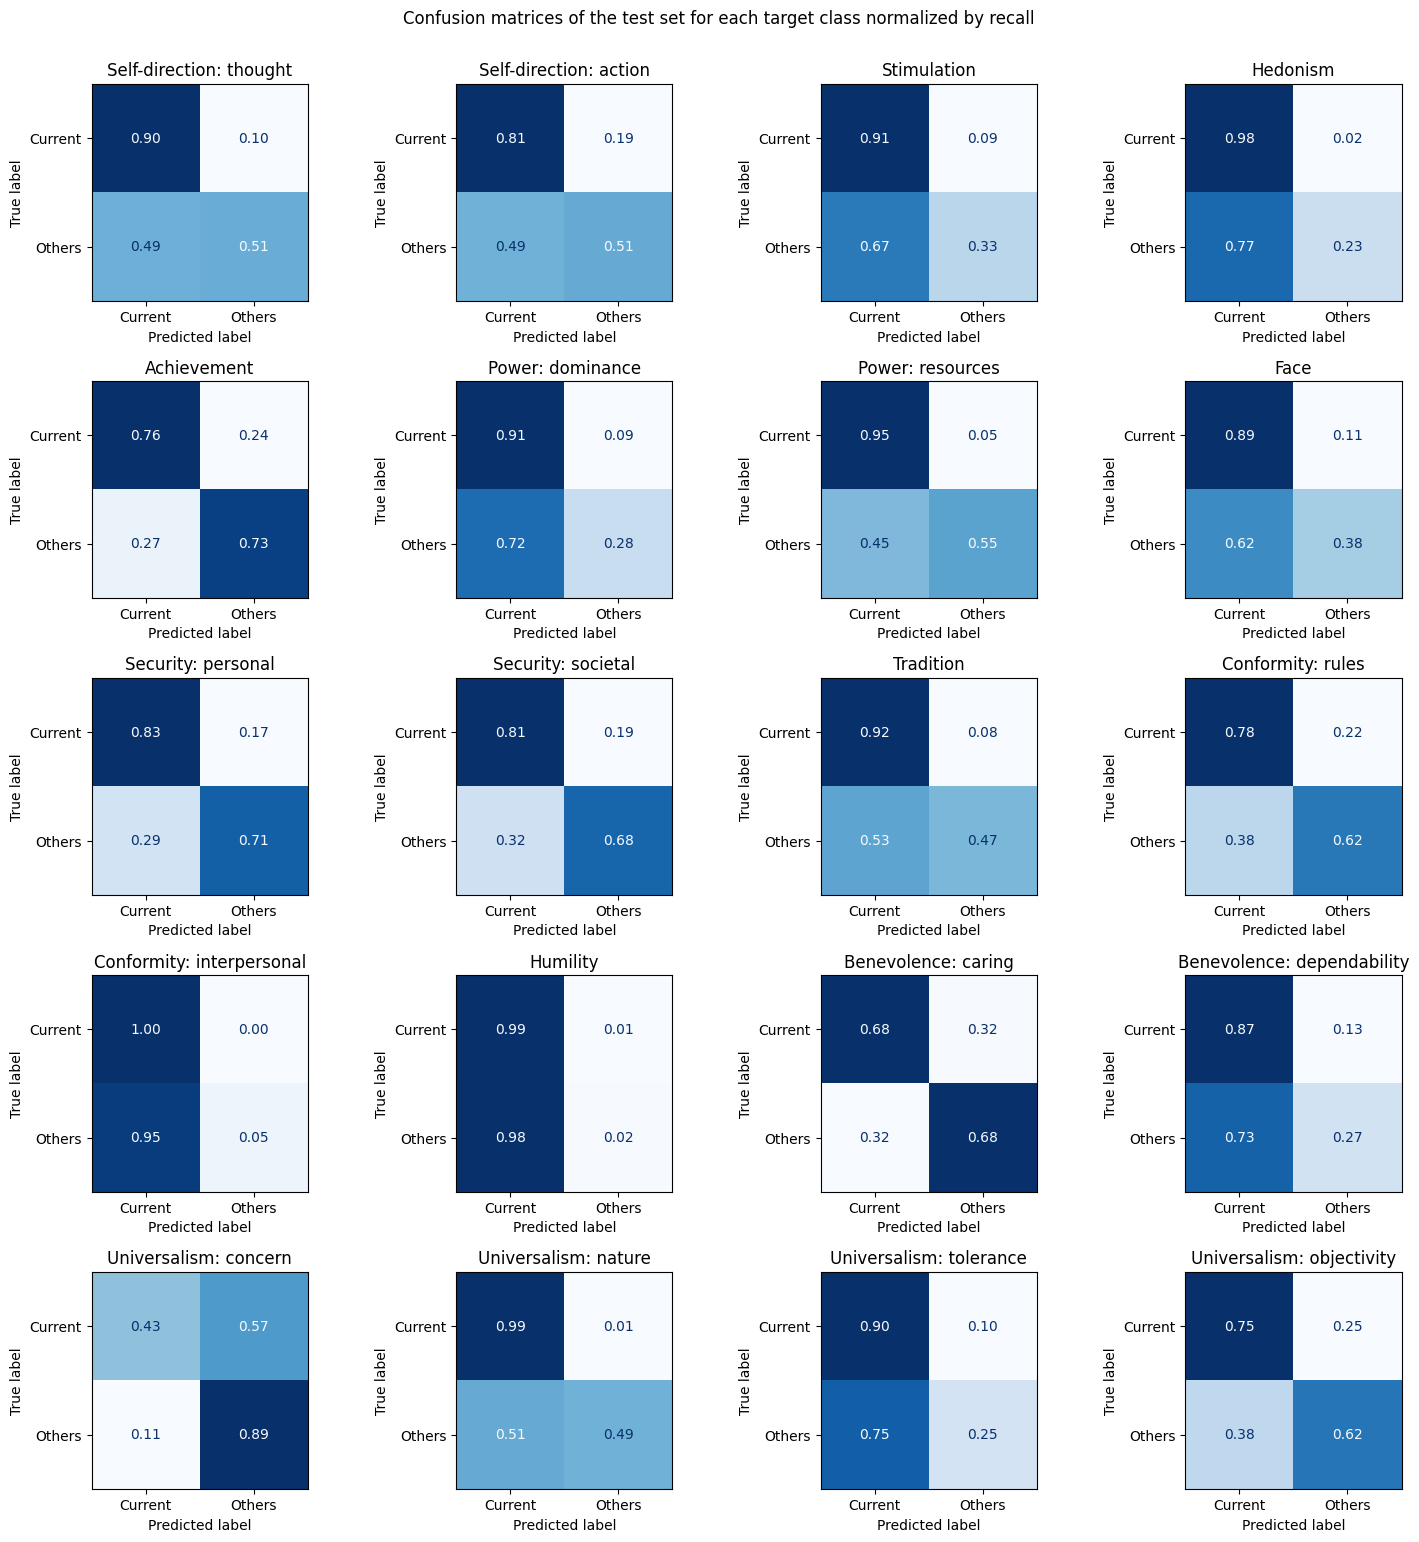

In [28]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test')

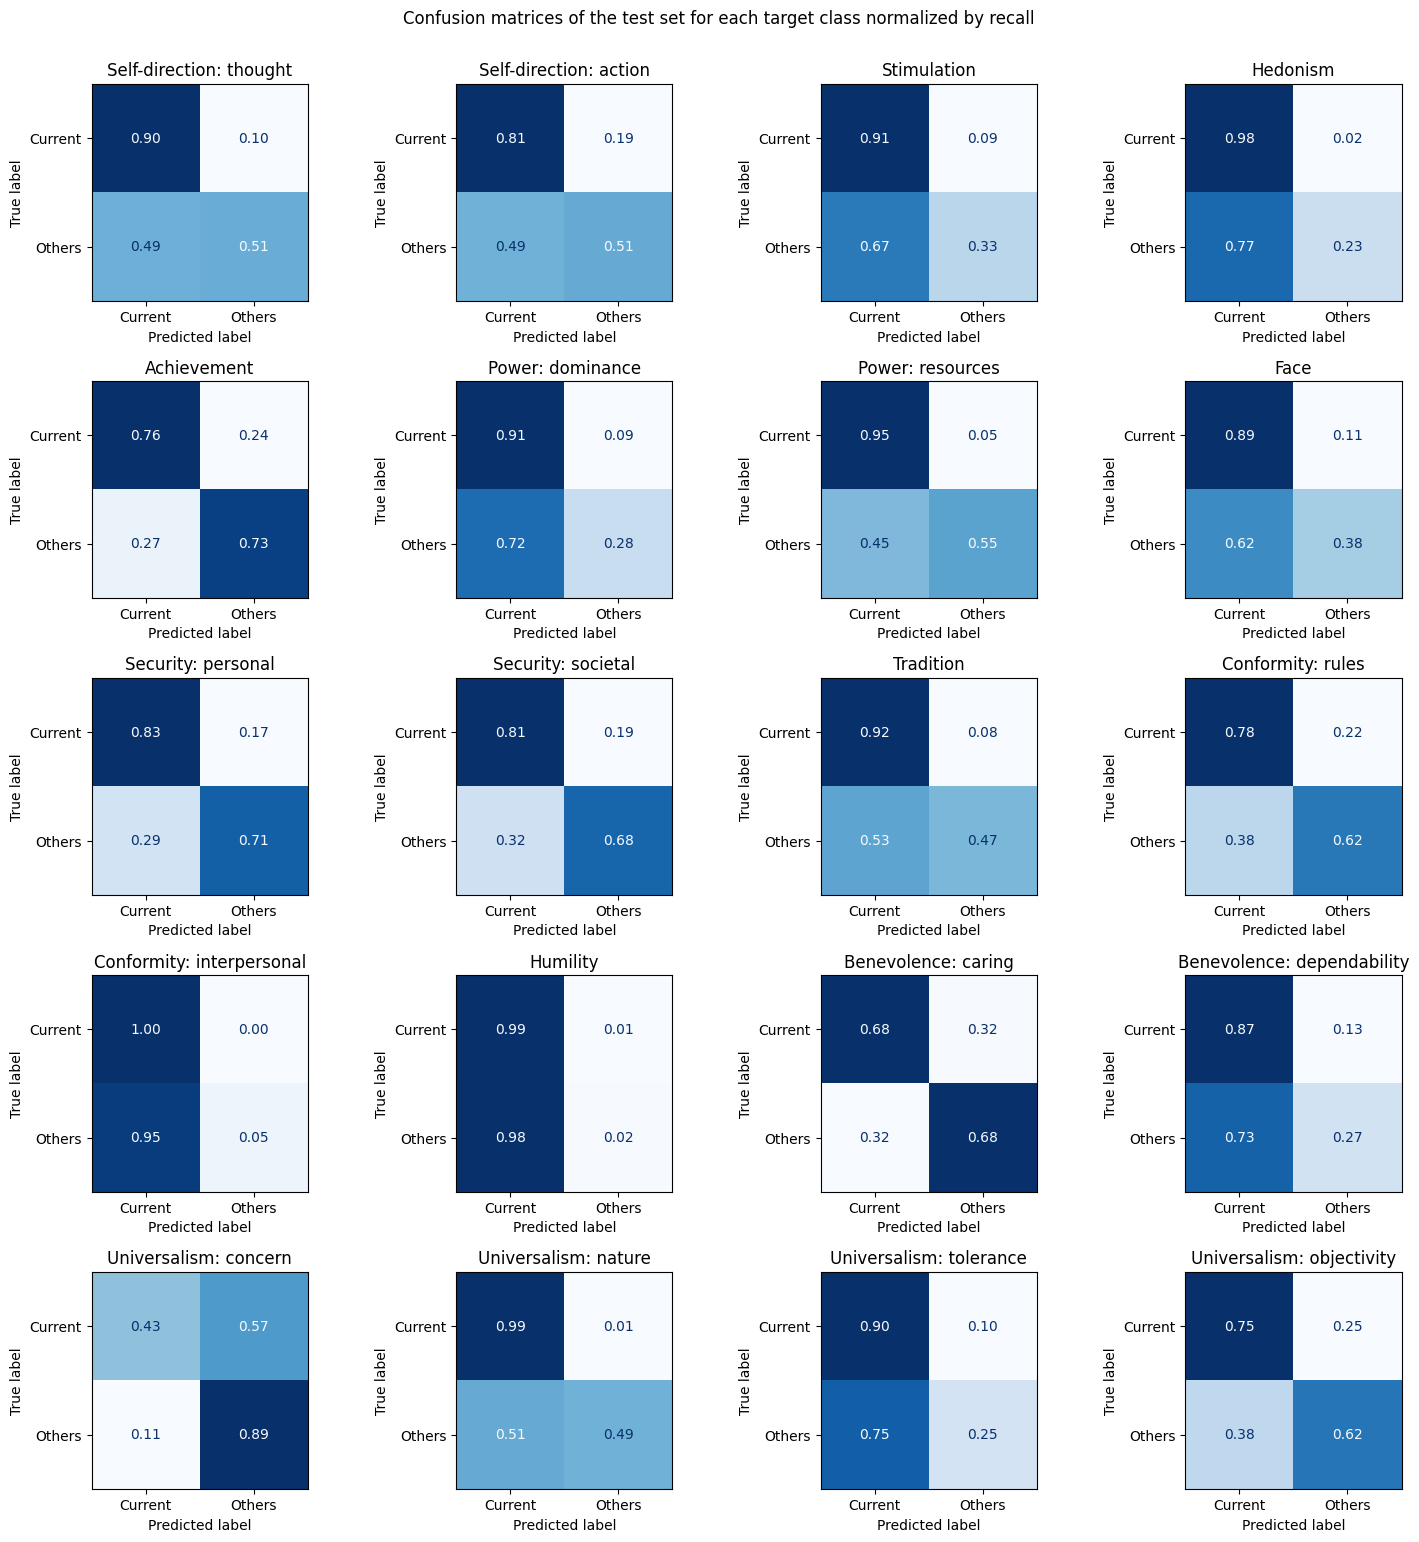

In [29]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test', normalize_by='recall')